In [1]:
import logging
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras as keras
import pickle
import math
import time
import shutil
import glob
import random as rd

from __future__ import print_function
import sys

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
count = 0
countBothWays = 0

onionAddressData = {}

flow_size = 100

negetive_samples = 9
BATCH_SIZE = 128
EPOCH_COUNT = 200
learn_rate=0.0001

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
keras.backend.set_session(session)

datasetScalerTimes = 1000
datasetScalerSizes = 1/1000

CNN_21_41 = {'kernelSize1':[2, 30], 'stride1':[2,1], 'kernelSize2':[4, 10], 'stride2':[4,1]} 

reduce_factor = 16

parameters ={
    'cnn_secondStage_21_41':CNN_21_41,
}
    
baseDatasetPath = '/home/jupyter-atse/datasets/'

metaDataPairsFolders = pickle.load(open(baseDatasetPath + 'metaDataPairsFolders', 'rb'))
trainPairsFolders = pickle.load(open(baseDatasetPath + 'trainPairsFolders', 'rb'))
testPairsFolders = pickle.load(open(baseDatasetPath + 'testPairsFolders', 'rb'))

onionAddressData = metaDataPairsFolders['onionAddressData']

In [3]:
def generateDataset(pairsFoldersInput):

    global negetive_samples, flow_size, onionAddressData, graphTitle

    for onionUrl in onionAddressData:
        onionAddressData[onionUrl]['connectionIndex'] = 0

    index = 0

    l2s=np.zeros((len(pairsFoldersInput)*(negetive_samples+1),8,flow_size,1))
    labels=np.zeros((len(pairsFoldersInput)*(negetive_samples+1),1))
    for pairFolder in pairsFoldersInput:
        
        clientTimesIn = pairFolder['clientFlow']['timesIn']
        clientTimesOut = pairFolder['clientFlow']['timesOut']
        clientSizesIn = pairFolder['clientFlow']['sizesIn']
        clientSizesOut = pairFolder['clientFlow']['sizesOut']

        hsTimesIn = pairFolder['hsFlow']['timesIn']
        hsTimesOut = pairFolder['hsFlow']['timesOut']
        hsSizesIn = pairFolder['hsFlow']['sizesIn']
        hsSizesOut = pairFolder['hsFlow']['sizesOut']


        l2s[index,0,:len(clientTimesIn[:flow_size]),0]=np.array(clientTimesIn[:flow_size])*datasetScalerTimes
        l2s[index,1,:len(hsTimesOut[:flow_size]),0]=np.array(hsTimesOut[:flow_size])*datasetScalerTimes
        l2s[index,2,:len(hsTimesIn[:flow_size]),0]=np.array(hsTimesIn[:flow_size])*datasetScalerTimes
        l2s[index,3,:len(clientTimesOut[:flow_size]),0]=np.array(clientTimesOut[:flow_size])*datasetScalerTimes

        l2s[index,4,:len(clientSizesIn[:flow_size]),0]=np.array(clientSizesIn[:flow_size])*datasetScalerSizes
        l2s[index,5,:len(hsSizesOut[:flow_size]),0]=np.array(hsSizesOut[:flow_size])*datasetScalerSizes
        l2s[index,6,:len(hsSizesIn[:flow_size]),0]=np.array(hsSizesIn[:flow_size])*datasetScalerSizes
        l2s[index,7,:len(clientSizesOut[:flow_size]),0]=np.array(clientSizesOut[:flow_size])*datasetScalerSizes

        labels[index, 0] = 1

        index += 1

        random = list(range(len(pairsFoldersInput)))
        np.random.shuffle(random)
        negetive_samples_current = 0
        for negetive_pair_index in random:

            #skip if is the original correlated pair
            if pairsFoldersInput[negetive_pair_index]['hsFolder'] == pairFolder['hsFolder']:
                continue

            hsTimesIn = pairsFoldersInput[negetive_pair_index]['hsFlow']['timesIn']
            hsTimesOut = pairsFoldersInput[negetive_pair_index]['hsFlow']['timesOut']
            hsSizesIn = pairsFoldersInput[negetive_pair_index]['hsFlow']['sizesIn']
            hsSizesOut = pairsFoldersInput[negetive_pair_index]['hsFlow']['sizesOut']

            
            l2s[index,0,:len(clientTimesIn[:flow_size]),0]=np.array(clientTimesIn[:flow_size])*datasetScalerTimes
            l2s[index,1,:len(hsTimesOut[:flow_size]),0]=np.array(hsTimesOut[:flow_size])*datasetScalerTimes
            l2s[index,2,:len(hsTimesIn[:flow_size]),0]=np.array(hsTimesIn[:flow_size])*datasetScalerTimes
            l2s[index,3,:len(clientTimesOut[:flow_size]),0]=np.array(clientTimesOut[:flow_size])*datasetScalerTimes

            l2s[index,4,:len(clientSizesIn[:flow_size]),0]=np.array(clientSizesIn[:flow_size])*datasetScalerSizes
            l2s[index,5,:len(hsSizesOut[:flow_size]),0]=np.array(hsSizesOut[:flow_size])*datasetScalerSizes
            l2s[index,6,:len(hsSizesIn[:flow_size]),0]=np.array(hsSizesIn[:flow_size])*datasetScalerSizes
            l2s[index,7,:len(clientSizesOut[:flow_size]),0]=np.array(clientSizesOut[:flow_size])*datasetScalerSizes


            labels[index, 0] = 0

            index += 1

            negetive_samples_current += 1
            if negetive_samples_current >= negetive_samples:
                break

        onionAddressData[pairFolder['onionAddress']]['connectionIndex'] += 1

    return l2s, labels

In [ ]:
%%capture output
    
models = [0] * 4
precision_value = []
execution_time = []

for modelParametersKey in parameters:
    
    for z in range(4):

        #create directory for models
        if not os.path.exists(modelParametersKey):
            os.makedirs(modelParametersKey)


        #model definition
        models[z] = keras.Sequential()

        orig = [2000/reduce_factor, 1000/reduce_factor, 49600/reduce_factor, 3000/reduce_factor, 800/reduce_factor, 100/reduce_factor]
        dropout_prob = 0.4

        models[z].add(keras.layers.Conv2D(int(orig[0]), input_shape=[8, flow_size, 1], kernel_size=[2,15+z], strides=parameters[modelParametersKey]['stride1'], padding='VALID', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
        models[z].add(keras.layers.Activation('relu'))
        models[z].add(keras.layers.MaxPool2D(pool_size=(1, 5), strides=(1, 1+i), padding='VALID'))

        models[z].add(keras.layers.Conv2D(int(orig[1]), kernel_size=parameters[modelParametersKey]['kernelSize2'], strides=parameters[modelParametersKey]['stride2'], padding='VALID', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
        models[z].add(keras.layers.Activation('relu'))
        models[z].add(keras.layers.MaxPool2D(pool_size=(1, 5), strides=(1, 1), padding='VALID')) 

        models[z].add(keras.layers.Flatten())
        models[z].add(keras.layers.Dense(int(orig[3]), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
        models[z].add(keras.layers.Activation('relu'))
        models[z].add(keras.layers.Dropout(dropout_prob))
        models[z].add(keras.layers.Dense(int(orig[4]), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
        models[z].add(keras.layers.Activation('relu'))
        models[z].add(keras.layers.Dropout(dropout_prob))
        models[z].add(keras.layers.Dense(int(orig[5]), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
        models[z].add(keras.layers.Activation('relu'))
        models[z].add(keras.layers.Dropout(dropout_prob))
        models[z].add(keras.layers.Dense(1))

        def customLoss(y_true,y_pred):
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y_true),name='loss_sigmoid')



        models[z].compile(loss=customLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['accuracy'])

        # custom function
        def sigmoid(x):
            if x < -150:
                x = -150
            if x > 150:
                x = 150
            return 1 / (1 + math.exp(-x))

        # define vectorized sigmoid
        sigmoid_v = np.vectorize(sigmoid)



        losses = [10, 10]
        saveNames = ['', '']
        precisionBest = 0
        saveNamePrecisionBest = ''
        f1_05 = 0
        saveNameF1_05 = ''

        correlatedPerRound = 10


        tpBest = 0
        tp = { 0.01 : 0, 0.05 : 0, 0.1 : 0, 0.2 : 0, 0.3 : 0, 0.4 : 0, 0.5 : 0, 0.6 : 0, 0.7 : 0, 0.8 : 0, 0.9 : 0, 0.95 : 0, 0.99 : 0}
        fpBest = 0
        fp = { 0.01 : 0, 0.05 : 0, 0.1 : 0, 0.2 : 0, 0.3 : 0, 0.4 : 0, 0.5 : 0, 0.6 : 0, 0.7 : 0, 0.8 : 0, 0.9 : 0, 0.95 : 0, 0.99 : 0}
        tn = { 0.01 : 0, 0.05 : 0, 0.1 : 0, 0.2 : 0, 0.3 : 0, 0.4 : 0, 0.5 : 0, 0.6 : 0, 0.7 : 0, 0.8 : 0, 0.9 : 0, 0.95 : 0, 0.99 : 0}
        fn = { 0.01 : 0, 0.05 : 0, 0.1 : 0, 0.2 : 0, 0.3 : 0, 0.4 : 0, 0.5 : 0, 0.6 : 0, 0.7 : 0, 0.8 : 0, 0.9 : 0, 0.95 : 0, 0.99 : 0}

        start = time.time()
        try:

            for epoch in tqdm.tqdm(range(EPOCH_COUNT)):
                l2s, labels = generateDataset(trainPairsFolders)
                rr= list(range(len(l2s)))
                np.random.shuffle(rr)
                l2s=l2s[rr]
                labels=labels[rr]

                history = models[z].fit(l2s, labels, batch_size=BATCH_SIZE, verbose=0)
                loss = history.history['loss'][-1]
                #print("Epoch:", epoch, "loss:", loss)


                path = 'epoch' + str(epoch) + '_loss' + str(loss) + '/cp.ckpt'
                models[z].save_weights(modelParametersKey + '/' + 'last_' + path)
                for filename in glob.glob(modelParametersKey + '/' + 'last_' + 'epoch' + str(epoch-1) + '*'):
                    shutil.rmtree(filename)




                #save model based on precision
                if epoch % 3 == 0 and epoch > 0:
                    for onionUrl in onionAddressData:
                        onionAddressData[onionUrl]['connectionIndex'] = 0

                    for i in tqdm.tqdm(range(len(testPairsFolders)//correlatedPerRound-1)):
                        l2s_test=np.zeros(((negetive_samples+1)*correlatedPerRound,8,flow_size,1))
                        labels_test=np.zeros(((negetive_samples+1)*correlatedPerRound))

                        index = 0

                        for pairFolder in testPairsFolders[i*correlatedPerRound:(i+1)*correlatedPerRound]:

                            clientTimesIn = pairFolder['clientFlow']['timesIn']
                            clientTimesOut = pairFolder['clientFlow']['timesOut']
                            clientSizesIn = pairFolder['clientFlow']['sizesIn']
                            clientSizesOut = pairFolder['clientFlow']['sizesOut']

                            hsTimesIn = pairFolder['hsFlow']['timesIn']
                            hsTimesOut = pairFolder['hsFlow']['timesOut']
                            hsSizesIn = pairFolder['hsFlow']['sizesIn']
                            hsSizesOut = pairFolder['hsFlow']['sizesOut']                  

                            l2s_test[index,0,:len(clientTimesIn[:flow_size]),0]=np.array(clientTimesIn[:flow_size])*datasetScalerTimes
                            l2s_test[index,1,:len(hsTimesOut[:flow_size]),0]=np.array(hsTimesOut[:flow_size])*datasetScalerTimes
                            l2s_test[index,2,:len(hsTimesIn[:flow_size]),0]=np.array(hsTimesIn[:flow_size])*datasetScalerTimes
                            l2s_test[index,3,:len(clientTimesOut[:flow_size]),0]=np.array(clientTimesOut[:flow_size])*datasetScalerTimes

                            l2s_test[index,4,:len(clientSizesIn[:flow_size]),0]=np.array(clientSizesIn[:flow_size])*datasetScalerSizes
                            l2s_test[index,5,:len(hsSizesOut[:flow_size]),0]=np.array(hsSizesOut[:flow_size])*datasetScalerSizes
                            l2s_test[index,6,:len(hsSizesIn[:flow_size]),0]=np.array(hsSizesIn[:flow_size])*datasetScalerSizes
                            l2s_test[index,7,:len(clientSizesOut[:flow_size]),0]=np.array(clientSizesOut[:flow_size])*datasetScalerSizes

                            labels_test[index] = 1

                            index += 1

                            random = list(range(len(testPairsFolders)))
                            np.random.shuffle(random)
                            negetive_samples_current = 0
                            for negetive_pair_index in random:

                                #if is the corresponding 
                                if testPairsFolders[negetive_pair_index]['hsFolder'] == pairFolder['hsFolder']:
                                    continue


                                hsTimesIn = testPairsFolders[negetive_pair_index]['hsFlow']['timesIn']
                                hsTimesOut = testPairsFolders[negetive_pair_index]['hsFlow']['timesOut']
                                hsSizesIn = testPairsFolders[negetive_pair_index]['hsFlow']['sizesIn']
                                hsSizesOut = testPairsFolders[negetive_pair_index]['hsFlow']['sizesOut']   


                                l2s_test[index,0,:len(clientTimesIn[:flow_size]),0]=np.array(clientTimesIn[:flow_size])*datasetScalerTimes
                                l2s_test[index,1,:len(hsTimesOut[:flow_size]),0]=np.array(hsTimesOut[:flow_size])*datasetScalerTimes
                                l2s_test[index,2,:len(hsTimesIn[:flow_size]),0]=np.array(hsTimesIn[:flow_size])*datasetScalerTimes
                                l2s_test[index,3,:len(clientTimesOut[:flow_size]),0]=np.array(clientTimesOut[:flow_size])*datasetScalerTimes

                                l2s_test[index,4,:len(clientSizesIn[:flow_size]),0]=np.array(clientSizesIn[:flow_size])*datasetScalerSizes
                                l2s_test[index,5,:len(hsSizesOut[:flow_size]),0]=np.array(hsSizesOut[:flow_size])*datasetScalerSizes
                                l2s_test[index,6,:len(hsSizesIn[:flow_size]),0]=np.array(hsSizesIn[:flow_size])*datasetScalerSizes
                                l2s_test[index,7,:len(clientSizesOut[:flow_size]),0]=np.array(clientSizesOut[:flow_size])*datasetScalerSizes


                                labels_test[index] = 0

                                index += 1

                                negetive_samples_current += 1
                                if negetive_samples_current >= negetive_samples:
                                    break

                        #ignore batch size and use batches of negetive_samples+1
                        prediction = models[z].predict(l2s_test)
                        results = sigmoid_v(prediction).tolist()
 
        except KeyboardInterrupt:
            pass
        this_execution = np.zeros(10)
        l3s, labels3 = generateDataset(testPairsFolders)
        for j in range(10):
            start_test = time.time()
            test_loss, test_accuracy = models[z].evaluate(l3s,labels3, batch_size=BATCH_SIZE, verbose=1)
            end_test = time.time()
            this_execution[j] = end_test - start_test
        execution_time.append(np.min(this_execution))
        precision_value.append(test_accuracy)
    
print(execution_time)
print(precision_value)

In [ ]:
output.show()

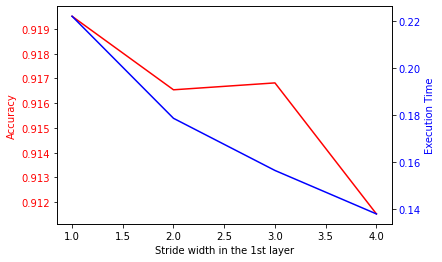

In [8]:
stride_values = []

for i in range(4):
    stride_values.append(1+i)

fig, ax1 = plt.subplots() 

ax1.set_xlabel('Stride width in the 1st layer') 
ax1.set_ylabel('Accuracy', color = 'red') 
ax1.plot(stride_values, precision_value, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Execution Time', color = 'blue') 
ax2.plot(stride_values, execution_time, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

plt.show()